In [33]:
#NOTE: This notebook extracts data directly from the Spotify API to live in various data sinks. It utilizes three different Spark
#Sessions and contexts. This file is not meant to be run in continuous order in its current state.
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import translate, split, col, expr, regexp_replace, lit,  round, monotonically_increasing_id, udf
#from pyspark.sql.types import StringType, FloatType
from pyspark.sql.types import *
print("Spark imported")

Spark imported


In [2]:
# ELASTICSEARCH CONFIGURATION
elastic_host = "elasticsearch"
elastic_port = "9200"
print("Elastic Variables set")

Elastic Variables set


In [3]:
# Elastic Spark init
spark = SparkSession.builder \
    .master("local") \
    .appName('jupyter-pyspark') \
    .config("spark.jars.packages","org.elasticsearch:elasticsearch-spark-20_2.12:7.15.0")\
    .config("spark.es.nodes", elastic_host) \
    .config("spark.es.port",elastic_port) \
    .getOrCreate()
sc = spark.sparkContext
sc.setLogLevel("ERROR")
print("Spark Context Created")

:: loading settings :: url = jar:file:/usr/local/spark-3.1.2-bin-hadoop3.2/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/jovyan/.ivy2/cache
The jars for the packages stored in: /home/jovyan/.ivy2/jars
org.elasticsearch#elasticsearch-spark-20_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-c5fb5a03-58c5-4757-af9f-835f2fcb6739;1.0
	confs: [default]
	found org.elasticsearch#elasticsearch-spark-20_2.12;7.15.0 in central
	found org.scala-lang#scala-reflect;2.12.8 in central
	found org.slf4j#slf4j-api;1.7.6 in central
	found commons-logging#commons-logging;1.1.1 in central
	found javax.xml.bind#jaxb-api;2.3.1 in central
	found com.google.protobuf#protobuf-java;2.5.0 in central
	found org.apache.spark#spark-yarn_2.12;2.4.4 in central
:: resolution report :: resolve 786ms :: artifacts dl 6ms
	:: modules in use:
	com.google.protobuf#protobuf-java;2.5.0 from central in [default]
	commons-logging#commons-logging;1.1.1 from central in [default]
	javax.xml.bind#jaxb-api;2.3.1 from central in [default]
	org.apache.spark#spark-yarn_2.12;2.4.4 

Spark Context Created


In [2]:
# neo4j Spark init
import pyspark
from pyspark.sql import SparkSession
# NEO4J  CONFIGURATION
bolt_url = "bolt://neo4j:7687"
# Spark init
spark = SparkSession.builder \
    .master("local") \
    .appName('jupyter-pyspark') \
    .getOrCreate()
sc = spark.sparkContext
sc.setLogLevel("ERROR")

23/06/18 23:40:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
! sudo cp /home/jovyan/work/jars/neo4j-connector-apache-spark_2.12-4.1.0_for_spark_3.jar /usr/local/spark/jars/neo4j-connector-apache-spark_2.12-4.1.0_for_spark_3.jar

In [4]:
#I needed to run an install on the VM for this library.
! pip install spotipy

In [5]:
# Import dependencies
import os
import pandas as pd
import numpy as np
import csv
import json
import time
from time import sleep
import seaborn as sns
import matplotlib.pyplot as plt

# Credentials and custom functions
# API dependencies
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# Set up the spotipy functions to work with any client ID and secret to use the API
cid = "e5782ba8210c46038a5abd23b85cf1f3"
secret = "6647157f91d94b459c86cdfefc8e2abc"
#Matts Info
#cid = "8408aab98cbc4373a59d9b419df71699"
#secret = "1ab5c6366a55440e9bf54cc5bd05b8b3"
ccm = SpotifyClientCredentials(client_id = cid, client_secret = secret)
sp = spotipy.Spotify(client_credentials_manager = ccm)
print("Dependencies imported and spotipy functions enabled")

Dependencies imported and spotipy functions enabled


In [6]:
# Function to get the top playlist for each country
def get_top_playlists(country_codes):
    country_names = []

    for i,t in enumerate(countries):
        for c in country_codes:
            if c in t:
                if len(sorted(t)[1])==2:
                    country_names.insert(list(country_codes).index(c), sorted(t)[0])
                else:
                    country_names.insert(list(country_codes).index(c), sorted(t)[1])
    pl_names = []
    pl_ids = []

    for c in country_codes:
        response = sp.featured_playlists(country = c)

        while response:
            playlists = response['playlists']
            for i, item in enumerate(playlists['items']):
                pl_names.append(item['name'])
                pl_ids.append(item['id'])

            if playlists['next']:
                response = sp.next(playlists)
            else:
                response = None

    keys = ['country_name','pl_name','pl_id']
    top_pl = {}

    for i in range(len(country_codes)):
        sub_dict = {keys[0]: country_names[i], keys[1]: pl_names[i], keys[2]: pl_ids[i]}
        top_pl[country_codes[i]] = sub_dict

    return top_pl
print("get_top_playlists function created")

get_top_playlists function created


In [7]:
# Function to extract tracks from a playlist thats longer than 100 songs
def get_playlist_tracks(playlist_id):
    results = sp.playlist_tracks(playlist_id)
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    return tracks
print("get_playlist_tracks function created")

get_playlist_tracks function created


In [8]:
def get_spotify_dataframes(playlist_name, playlist_id):
    # Set up empty lists for the relevant data
    artist_name, artist_id, album, album_id, track_name, track_ids, genre, popularity, explicit = [
    ], [], [], [], [], [], [], [], []

    # Use the get_playlist_tracks function to retrieve the track results
    track_results = get_playlist_tracks(playlist_id)

    for t in track_results:
        if t['track']:
            if sp.audio_features(t['track']['id'])[0]:
                try:
                    artist = t['track']['artists'][0]['name']
                    artist_name.append(artist)
                    artist_id.append(t['track']['artists'][0]['id'])
                    album.append(t['track']['album']['name'])
                    album_id.append(t['track']['album']['id'])
                    track_name.append(t['track']['name'])
                    track_ids.append(t['track']['id'])
                    genre.append(sp.artist(t['track']['artists'][0]['id'])['genres'])
                    popularity.append(t['track']['popularity'])
                    explicit.append(sp.track(t['track']['id'])['explicit'])
                except Exception as e:
                    print(
                        f"Error occurred while processing track: {t}. Error message: {str(e)}")
                    artist_name.append("")
                    artist_id.append("")
                    album.append("")
                    album_id.append("")
                    track_name.append("")
                    track_ids.append("")
                    genre.append("")
                    popularity.append("")
                    explicit.append("")
            else:
                next

    # Create a DataFrame with the basic song information and popularity
    tracks_df = spark.createDataFrame(zip(artist_name, artist_id, album, album_id, track_name, track_ids, genre, popularity, explicit),
                                      schema=['artist', 'artist_id', 'album', 'album_id', 'track_name', 'track_id', 'genre', 'popularity', 'explicit'])

    # Set up empty dictionary to hold the audio features
    audio_features = {}

    # Put all the ids in a list for the spotipy object to look up the audio features
    for idd in track_ids:
        try:
            audio_features[idd] = sp.audio_features(idd)[0]
        except Exception as e:
            print(
                f"Error occurred while retrieving audio features for track id: {idd}. Error message: {str(e)}")

    feature_list = ['key', 'tempo', 'time_signature', 'valence', 'liveness', 'energy', 'danceability', 'loudness',
                    'speechiness', 'acousticness', 'instrumentalness', 'mode', 'duration_ms']

    # Define a UDF to apply the lambda function
    extract_feature_udf = udf(
        lambda idd, feature: audio_features[idd][feature])

    # Add each audio feature to the tracks DataFrame
    for feature in feature_list:
        try:
            tracks_df = tracks_df.withColumn(
                feature, extract_feature_udf(col('track_id'), lit(feature)))
        except Exception as e:
            print(
                f"Error occurred while adding audio feature '{feature}' to DataFrame. Error message: {str(e)}")

    try:
        # Define column to normalize
        min_tempo_row = tracks_df.select(
            'tempo').agg({'tempo': 'min'}).collect()

        if min_tempo_row and min_tempo_row[0] and min_tempo_row[0][0] is not None:
            x = min_tempo_row[0][0]

            # Normalize the tempo variable
            tracks_df = tracks_df.withColumn(
                'norm_tempo', (tracks_df['tempo'] - x) / x)

            # Sort by popularity
            sorted_df = tracks_df.orderBy(col('popularity').desc())

            # Add additional columns
            sorted_df = sorted_df.withColumn('playlist_id', lit(playlist_id))
            sorted_df = sorted_df.withColumn(
                'top_playlist_name', lit(playlist_name))

            return sorted_df
        else:
            return None
    except Exception as e:
        print(
            f"Error occurred while normalizing tempo column. Error message: {str(e)}")
        return None


print("get_spotify_dataframes function created")


get_spotify_dataframes function created


In [9]:
#I utilized these next code chunks to test playlists from two different countries to ensure the function worked
#test = get_spotify_dataframes('State of Mind', '37i9dQZF1DX1YPTAhwehsC')
#test.printSchema()

In [10]:
#test2 = get_spotify_dataframes('late night vibes', '37i9dQZF1DXdQvOLqzNHSW')
#test2.printSchema()

In [11]:
def make_sp_dataset(country_codes):
    top_pl = get_top_playlists(country_codes)
    dfs = []

    for k, v in top_pl.items():
        print(f"Making dataframe for {k}: {v['country_name']}")
        new_df = get_spotify_dataframes(v['pl_name'], v['pl_id'])
        if new_df is not None:  # Check if new_df is not None
            new_df = new_df.withColumn('country_code', lit(k))
            new_df = new_df.withColumn('country', lit(v['country_name']))
            dfs.append(new_df)
        print('Pausing for 90 seconds...')
        time.sleep(90)

    if len(dfs) == 0:
        return None

    df = dfs[0]
    for i in range(1, len(dfs)):
        df = df.union(dfs[i])

    #df = df.withColumn("index", monotonically_increasing_id())

    print("Done!")
    return df
print("make_sp_dataset function created")

make_sp_dataset function created


In [12]:
# Function to convert a CSV to JSON
# Takes the file paths as arguments

from collections import OrderedDict

def make_json(csvFilePath, jsonFilePath):
    csv_rows = []
    with open(csvFilePath, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        title = reader.fieldnames
        for row in reader:
            entry = OrderedDict()
            for field in title:
                entry[field] = row[field]
            csv_rows.append(entry)

    with open(jsonFilePath, 'w') as f:
        json.dump(csv_rows, f, sort_keys=True, indent=4, ensure_ascii=False)
        f.write('\n')
print("make_json function written")

make_json function written


In [13]:
countries = [
            #A
            {"AD", "Andorra"},
            {"AE", "United Arab Emirates"},
            {"AF", "Afghanistan"},
            {"AG", "Antigua and Barbuda"},
            {"AI", "Anguilla"},
            {"AL", "Albania"},
            {"AM", "Armenia"},
            {"AO", "Angola"},
            {"AQ", "Antarctica"},
            {"AR", "Argentina"},
            {"AS", "American Samoa"},
            {"AT", "Austria"},
            {"AU", "Australia"},
            {"AW", "Aruba"},
            {"AX", "Åland Islands"},
            {"AZ", "Azerbaijan"},
            #B
            {"BA", "Bosnia and Herzegovina"},
            {"BB", "Barbados"},
            {"BD", "Bangladesh"},
            {"BE", "Belgium"},
            {"BF", "Burkina Faso"},
            {"BG", "Bulgaria"},
            {"BH", "Bahrain"},
            {"BI", "Burundi"},
            {"BJ", "Benin"},
            {"BL", "Saint Barthélemy"},
            {"BM", "Bermuda"},
            {"BN", "Brunei Darussalam"},
            {"BO", "Bolivia, Plurinational State of"},
            {"BQ", "Bonaire, Sint Eustatius and Saba"},
            {"BR", "Brazil"},
            {"BS", "Bahamas"},
            {"BT", "Bhutan"},
            {"BV", "Bouvet Island"},
            {"BW", "Botswana"},
            {"BY", "Belarus"},
            {"BZ", "Belize"},
            #C
            {"CA","Canada"},
            {"CC","Cocos (Keeling) Islands"},
            {"CD","Congo, the Democratic Republic of"},
            {"CF","Central African Republic"},
            {"CG","Congo"},
            {"CH","Switzerland"},
            {"CI","Côte d'Ivoire"},
            {"CK","Cook Islands"},
            {"CL","Chile"},
            {"CM","Cameroon"},
            {"CN","China"},
            {"CO","Colombia"},
            {"CR","Costa Rica"},
            {"CU","Cuba"},
            {"CV","Cabo Verde"},
            {"CW","Curaçao"},
            {"CX","Christmas Island"},
            {"CY","Cyprus"},
            {"CZ","Czech Republic"},
            #D
            {"DE","Germany"},
            {"DJ","Djibouti"},
            {"DK","Denmark"},
            {"DM","Dominica"},
            {"DO","Dominican Republic"},
            {"DZ","Algeria"},
            #E
            {"EC","Ecuador"},
            {"EE","Estonia"},
            {"EG","Egypt"},
            {"EH","Western Sahara"},
            {"ER","Eritrea"},
            {"ES","Spain"},
            {"ET","Ethiopia"},
            #F
            {"FI","Finland"},
            {"FJ","Fiji"},
            {"FK","Falkland Islands (Malvinas)"},
            {"FM","Micronesia, Federated States of"},
            {"FO","Faroe Islands"},
            {"FR","France"},
            #G
            {"GA","Gabon"},
            {"GB","United Kingdom of Great Britain and Northern Ireland"},
            {"GD","Grenada"},
            {"GE","Georgia"},
            {"GF","French Guiana"},
            {"GG","Guernsey"},
            {"GH","Ghana"},
            {"GI","Gibraltar"},
            {"GL","Greenland"},
            {"GM","Gambia"},
            {"GN","Guinea"},
            {"GP","Guadeloupe"},
            {"GQ","Equatorial Guinea"},
            {"GR","Greece"},
            {"GS","South Georgia and the South Sandwich Islands"},
            {"GT","Guatemala"},
            {"GU","Guam"},
            {"GW","Guinea-Bissau"},
            {"GY","Guyana"},
            #H
            {"HK","Hong Kong"},
            {"HM","Heard Island and McDonalds Islands"},
            {"HN","Honduras"},
            {"HR","Croatia"},
            {"HT","Haiti"},
            {"HU","Hungary"},
            #I
            {"ID","Indonesia"},
            {"IE","Ireland"},
            {"IL","Israel"},
            {"IM","Isle of Man"},
            {"IN","India"},
            {"IO","British Indian Ocean Territory"},
            {"IQ","Iraq"},
            {"IR","Iran, Islamic Republic of"},
            {"IS","Iceland"},
            {"IT","Italy"},
            #J
            {"JE","Jersey"},
            {"JM","Jamaica"},
            {"JO","Jordan"},
            {"JP","Japan"},
            #K
            {"KE","Kenya"},
            {"KG","Kyrgyzstan"},
            {"KH","Cambodia"},
            {"KI","Kiribati"},
            {"KM","Comoros"},
            {"KN","Saint Kitts and Nevis"},
            {"KP","Korea, Democratic People's Republic of"},
            {"KR","Korea, Republic of"},
            {"KW","Kuwait"},
            {"KY","Cayman Islands"},
            {"KZ","Kazakhstan"},
            #L
            {"LA","Lao People's Democratic Republic"},
            {"LB","Lebanon"},
            {"LC","Saint Lucia"},
            {"LI","Liechtenstein"},
            {"LK","Sri Lanka"},
            {"LR","Liberia"},
            {"LS","Lesotho"},
            {"LT","Lithuania"},
            {"LU","Luxembourg"},
            {"LV","Latvia"},
            #M
            {"MA","Morocco"},
            {"MC","Monaco"},
            {"MD","Moldova, Republic of"},
            {"ME","Montenegro"},
            {"MF","Saint Martin (French part)"},
            {"MG","Madagascar"},
            {"MH","Marshall Islands"},
            {"MK","Macedonia, the former Yugoslav Republic of"},
            {"ML","Mali"},
            {"MM","Myanmar"},
            {"MN","Mongolia"},
            {"MO","Macao"},
            {"MP","Northern Mariana Islands"},
            {"MQ","Martinique"},
            {"MR","Mauritania"},
            {"MS","Montserrat"},
            {"MT","Malta"},
            {"MU","Mauritius"},
            {"MV","Maldives"},
            {"MW","Malawi"},
            {"MX","Mexico"},
            {"MY","Malaysia"},
            {"MZ","Mozambique"},
            #N
            {"NA","Namibia"},
            {"NC","New Caledonia"},
            {"NE","Niger"},
            {"NF","Norfolk Island"},
            {"NG","Nigeria"},
            {"NI","Nicaragua"},
            {"NL","Netherlands"},
            {"NO","Norway"},
            {"NP","Nepal"},
            {"NR","Nauru"},
            {"NU","Niue"},
            {"NZ","New Zealand"},
            #O
            {"OM","Oman"},
            #P
            {"PA","Panama"},
            {"PE","Peru"},
            {"PF","French Polynesia"},
            {"PG","Papua New Guinea"},
            {"PH","Philippines"},
            {"PK","Pakistan"},
            {"PL","Poland"},
            {"PM","Saint Pierre and Miquelon"},
            {"PN","Pitcairn"},
            {"PR","Puerto Rico"},
            {"PS","Palestine, State of"},
            {"PT","Portugal"},
            {"PW","Palau"},
            {"PY","Paraguay"},
            #Q
            {"QA","Qatar"},
            #R
            {"RE","Réunion"},
            {"RO","Romania"},
            {"RS","Serbia"},
            {"RU","Russian Federation"},
            {"RW","Rwanda"},
            #S
            {"SA","Saudi Arabia"},
            {"SB","Solomon Islands"},
            {"SC","Seychelles"},
            {"SD","Sudan"},
            {"SE","Sweden"},
            {"SG","Singapore"},
            {"SH","Saint Helena, Ascension and Tristan da Cunha"},
            {"SI","Slovenia"},
            {"SJ","Svalbard and Jan Mayen"},
            {"SK","Slovakia"},
            {"SL","Sierra Leone"},
            {"SM","San Marino"},
            {"SN","Senegal"},
            {"SO","Somalia"},
            {"SR","Suriname"},
            {"SS","South Sudan"},
            {"ST","Sao Tome and Principe"},
            {"SV","El Salvador"},
            {"SX","Sint Maarten (Dutch part)"},
            {"SY","Syrian Arab Republic"},
            {"SZ","Swaziland"},
            #T
            {"TC","Turks and Caicos Islands"},
            {"TD","Chad"},
            {"TF","French Southern Territories"},
            {"TG","Togo"},
            {"TH","Thailand"},
            {"TJ","Tajikistan"},
            {"TK","Tokelau"},
            {"TL","Timor-Leste"},
            {"TM","Turkmenistan"},
            {"TN","Tunisia"},
            {"TO","Tonga"},
            {"TR","Turkey"},
            {"TT","Tuvalu"},
            {"TW","Taiwan, Province of China"},
            {"TZ","Tanzania, United Republic of"},
            #U
            {"UA","Ukraine"},
            {"UG","Uganda"},
            {"UM","United States Minor Outlying Islands"},
            {"US","United States of America"},
            {"UY","Uruguay"},
            {"UZ","Uzbekistan"},
            #V
            {"VA","Holy See"},
            {"VC","Saint Vincent and the Grenadines"},
            {"VE","Venezuela, Bolivarian Republic of"},
            {"VG","Virgin Islands, British"},
            {"VI","Virgin Islands, U.S."},
            {"VN","Viet Nam"},
            {"VU","Vanuatu"},
            #W
            {"WF","Wallis and Futuna"},
            {"WS","Samoa"},
            #Y
            {"YE","Yemen"},
            {"YT","Mayotte"},
            #Z
            {"ZA","South Africa"},
            {"ZM","Zambia"},
            {"ZW","Zimbabwe"}
]
print("Countries list created")

Countries list created


In [14]:
######get a list of just the country codes
countryCodeList=[]
for i in range(len(countries)):
    for x in countries[i]:
        if len(x)==2:
            countryCodeList.append(x)

In [15]:
#remove country codes that don't work
'''working_countrycode_list = []
fail_countrycode_list = []
for i in countryCodeList:
    try:
        get_top_playlists([i])
        working_countrycode_list.append(i)
    except:
        print(f'{i} does not have Spotify yet')
        fail_countrycode_list.append(i)'''

#results in 181 countries/country codes that we can get featured playlists for, 66 countries taht we cannot:
working_countrycode_list=['AD',
 'AE',
 'AG',
 'AL',
 'AM',
 'AO',
 'AR',
 'AT',
 'AU',
 'AZ',
 'BA',
 'BB',
 'BD',
 'BE',
 'BF',
 'BG',
 'BH',
 'BI',
 'BJ',
 'BN',
 'BO',
 'BR',
 'BS',
 'BT',
 'BW',
 'BY',
 'BZ',
 'CA',
 'CD',
 'CG',
 'CH',
 'CI',
 'CL',
 'CM',
 'CO',
 'CR',
 'CV',
 'CW',
 'CY',
 'CZ',
 'DE',
 'DJ',
 'DK',
 'DM',
 'DO',
 'DZ',
 'EC',
 'EE',
 'EG',
 'ES',
 'ET',
 'FI',
 'FJ',
 'FM',
 'FR',
 'GA',
 'GB',
 'GD',
 'GE',
 'GH',
 'GM',
 'GN',
 'GQ',
 'GR',
 'GT',
 'GW',
 'GY',
 'HK',
 'HN',
 'HR',
 'HT',
 'HU',
 'ID',
 'IE',
 'IL',
 'IN',
 'IQ',
 'IS',
 'IT',
 'JM',
 'JO',
 'JP',
 'KE',
 'KG',
 'KH',
 'KI',
 'KM',
 'KN',
 'KR',
 'KW',
 'KZ',
 'LA',
 'LB',
 'LC',
 'LI',
 'LK',
 'LR',
 'LS',
 'LT',
 'LU',
 'LV',
 'MA',
 'MC',
 'MD',
 'ME',
 'MG',
 'MH',
 'MK',
 'ML',
 'MN',
 'MO',
 'MR',
 'MT',
 'MU',
 'MV',
 'MW',
 'MX',
 'MY',
 'MZ',
 'NA',
 'NE',
 'NG',
 'NI',
 'NL',
 'NO',
 'NP',
 'NR',
 'NZ',
 'OM',
 'PA',
 'PE',
 'PG',
 'PH',
 'PK',
 'PL',
 'PS',
 'PT',
 'PW',
 'PY',
 'QA',
 'RO',
 'RS',
 'RW',
 'SA',
 'SB',
 'SC',
 'SE',
 'SG',
 'SI',
 'SK',
 'SL',
 'SM',
 'SN',
 'SR',
 'ST',
 'SV',
 'SZ',
 'TD',
 'TG',
 'TH',
 'TJ',
 'TL',
 'TN',
 'TO',
 'TR',
 'TT',
 'TW',
 'TZ',
 'UA',
 'UG',
 'US',
 'UY',
 'UZ',
 'VC',
 'VE',
 'VN',
 'VU',
 'WS',
 'ZA',
 'ZM',
 'ZW']
fail_countrycode_list=['AF',
 'AI',
 'AQ',
 'AS',
 'AW',
 'AX',
 'BL',
 'BM',
 'BQ',
 'BV',
 'CC',
 'CF',
 'CK',
 'CN',
 'CU',
 'CX',
 'EH',
 'ER',
 'FK',
 'FO',
 'GF',
 'GG',
 'GI',
 'GL',
 'GP',
 'GS',
 'GU',
 'HM',
 'IM',
 'IO',
 'IR',
 'JE',
 'KP',
 'KY',
 'MF',
 'MM',
 'MP',
 'MQ',
 'MS',
 'NC',
 'NF',
 'NU',
 'PF',
 'PM',
 'PN',
 'PR',
 'RE',
 'RU',
 'SD',
 'SH',
 'SJ',
 'SO',
 'SS',
 'SX',
 'SY',
 'TC',
 'TF',
 'TK',
 'TM',
 'UM',
 'VA',
 'VG',
 'VI',
 'WF',
 'YE',
 'YT']

In [16]:
print(len(working_countrycode_list))
print(len(fail_countrycode_list))
#working_countrycode_list
#fail_countrycode_list

181
66


In [17]:
#######try to collect the data for all of the playlists

In [18]:
#####function for staggering data collection so that the API doesn't lock us out but also doesn't timeout
#This process took several days of running to finally finish. A command to import the final product has been added at the end.
'''count=0
schema = StructType([])
ds_full_list=spark.createDataFrame([],schema)
for i in range(0,len(working_countrycode_list)):
    temp_df=make_sp_dataset([working_countrycode_list[i]])
    if len(ds_full_list.columns)==0:
        ds_full_list=temp_df
    else:
        ds_full_list=ds_full_list.union(temp_df)
    count=count+1
    if count == 5:
        ds_full_list.toPandas().to_csv(f'data collection/top_playlists_{working_countrycode_list[0]}to{working_countrycode_list[i]}.csv', index = False, header = True)                 
        count=0
        print('Pausing for 3 minutes...')
        time.sleep(180)'''

world_top_playlists= pd.read_csv('world_top_playlists.csv')

In [19]:
#use the csv to json function to convert the world_top_playlists to a json:
make_json('world_top_playlists.csv', 'world_top_playlists.json')

In [20]:
##############Elastic work below

In [52]:
file_name = "file:///home/jovyan/work/final/world_top_playlists.csv"
df = spark.read.option("multiline", True).option("header", True).csv(file_name)
df = df.withColumn('genre', translate('genre', '[]\'', '')).withColumn('genreList', split(col('genre'), ',').alias('genreList')).drop('genre')
df = df.withColumn('explicit', expr("lower(explicit)"))
df.toPandas()

,artist,artist_id,album,album_id,track_name,track_id,popularity,explicit,key,tempo,...,acousticness,instrumentalness,mode,duration_ms,norm_tempo,playlist_id,top_playlist_name,country_code,country,genreList
0,Myke Towers,7iK8PXO48WeuP03g8YR51W,HORA CERO,2TmuI8IEYfaR7UFcI6YBnf,HORA CERO,5elf7rWt5uFffJvluUfwon,62,true,1,110.058,...,0.0308,0,1,231200,0.100502965,37i9dQZF1DWXJfnUiYjUKT,New Music Friday,AD,Andorra,"[reggaeton, trap latino, urbano latino]"
1,The Weeknd,1Xyo4u8uXC1ZmMpatF05PJ,The Idol Episode 2 (Music from the HBO Origina...,5bx7i3cuSfXBPF7Li8kUR7,Family (with Suzanna Son),1CatlSR0Kh0hsvGF2Z8l3s,58,false,9,139.209,...,0.863,3.02E-04,0,183885,0.391992561,37i9dQZF1DWXJfnUiYjUKT,New Music Friday,AD,Andorra,"[canadian contemporary r&b, canadian pop, pop]"
2,Laufey,7gW0r5CkdEUMm42w9XpyZO,Promise,21QZu3y3ewBQfmehshqMmZ,Promise,4LHq10VKu3fSIg8EeVRi09,42,false,5,76.244,...,0.935,8.50E-05,1,234267,-0.237613367,37i9dQZF1DWXJfnUiYjUKT,New Music Friday,AD,Andorra,[gen z singer-songwriter]
3,hemlocke springs,52PdgUJOjvS6Mpmjy1SAlx,heavun,6rIqnMYGM6a1CMD65is0Te,heavun,2gtEPlDqBTQ0uYMsaQebcH,42,false,11,147.008,...,0.0159,9.20E-04,0,196009,0.469977102,37i9dQZF1DWXJfnUiYjUKT,New Music Friday,AD,Andorra,[]
4,Killer Mike,2N4EYkIlG1kv25g6Wv8LGI,"SCIENTISTS & ENGINEERS [Feat. Future, Eryn All...",2dxxlSiPPh9v9TwSTpjLgo,"SCIENTISTS & ENGINEERS [Feat. Future, Eryn All...",2RHKzvzdxXANTOKtbZnuLo,41,true,5,140.225,...,0.688,0,0,253664,0.402151849,37i9dQZF1DWXJfnUiYjUKT,New Music Friday,AD,Andorra,"[alternative hip hop, atl hip hop, conscious..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17035,Marcel Kaestner,1pf4PEw1mtKsExJGa3gBdG,Frühlingsmorgen,6TQ6200VasnalwEkCgN9oq,Frühlingsmorgen,4DS4TRvAEwnpi5A1Qm2oCb,41,false,8,87.619,...,0.995,0.966,1,139125,-0.128151804,37i9dQZF1DX1s9knjP51Oa,calm vibes,ZW,Zimbabwe,"[background music, background piano]"
17036,Jackson Love,1UgWMZAdp3B83W5kgT6QEC,Story Time,0v547nlB4ydYCt26HXGxIl,Story Time,0cDZCWdR8bTlp7QRaBXBYD,40,false,11,74.929,...,0.995,0.9,1,129095,-0.254422974,37i9dQZF1DX1s9knjP51Oa,calm vibes,ZW,Zimbabwe,[background piano]
17037,Rasmus H Thomsen,42jjk371b9jW9zsmrMls10,Vejlefjord,1gt84E4kL8DdnXW1XlclX4,Vejlefjord,6ff7MgoSLL9Cxi3t2qYVnA,40,false,0,78.178,...,0.992,0.96,1,134067,-0.222093972,37i9dQZF1DX1s9knjP51Oa,calm vibes,ZW,Zimbabwe,[]
17038,Sean Larson,1BSEFOJzY8CtMOSxib4sfZ,Stars Forever,1sKfQiPP4YyYHQvybM86iB,Stars Forever,46vIeeL8h5pHZdm79kdP9X,40,false,2,65.109,...,0.995,0.947,1,188658,-0.352136361,37i9dQZF1DX1s9knjP51Oa,calm vibes,ZW,Zimbabwe,[]


In [44]:
! pip install elasticsearch

     |████████████████████████████████| 393 kB 2.8 MB/s eta 0:00:01
     |████████████████████████████████| 59 kB 2.5 MB/s  eta 0:00:01


In [53]:
# Write the DataFrame to Elasticsearch with the defined index and mapping
df.write.mode("Overwrite").format("es").save("spotify/_doc")
print("DataFrame written to elastic")

DataFrame written to elastic


In [50]:
###############neo4j work below

In [74]:
file_name = "file:///home/jovyan/work/final/world_top_playlists.json"
all_json_df=spark.read.option("multiline", True).option("header", True).json(file_name)
all_json_df=all_json_df.withColumn('genre',translate('genre','[]\'','')).withColumn('genreList',split(col('genre'),',').alias('genreList')).drop('genre')
all_json_df.toPandas()

,acousticness,album,album_id,artist,artist_id,country,country_code,danceability,duration_ms,energy,...,playlist_id,popularity,speechiness,tempo,time_signature,top_playlist_name,track_id,track_name,valence,genreList
0,0.0308,HORA CERO,2TmuI8IEYfaR7UFcI6YBnf,Myke Towers,7iK8PXO48WeuP03g8YR51W,Andorra,AD,0.721,231200,0.486,...,37i9dQZF1DWXJfnUiYjUKT,62,0.422,110.058,4,New Music Friday,5elf7rWt5uFffJvluUfwon,HORA CERO,0.612,"[reggaeton, trap latino, urbano latino]"
1,0.863,The Idol Episode 2 (Music from the HBO Origina...,5bx7i3cuSfXBPF7Li8kUR7,The Weeknd,1Xyo4u8uXC1ZmMpatF05PJ,Andorra,AD,0.406,183885,0.348,...,37i9dQZF1DWXJfnUiYjUKT,58,0.0285,139.209,3,New Music Friday,1CatlSR0Kh0hsvGF2Z8l3s,Family (with Suzanna Son),0.105,"[canadian contemporary r&b, canadian pop, pop]"
2,0.935,Promise,21QZu3y3ewBQfmehshqMmZ,Laufey,7gW0r5CkdEUMm42w9XpyZO,Andorra,AD,0.263,234267,0.112,...,37i9dQZF1DWXJfnUiYjUKT,42,0.0344,76.244,4,New Music Friday,4LHq10VKu3fSIg8EeVRi09,Promise,0.0903,[gen z singer-songwriter]
3,0.0159,heavun,6rIqnMYGM6a1CMD65is0Te,hemlocke springs,52PdgUJOjvS6Mpmjy1SAlx,Andorra,AD,0.619,196009,0.954,...,37i9dQZF1DWXJfnUiYjUKT,42,0.0346,147.008,4,New Music Friday,2gtEPlDqBTQ0uYMsaQebcH,heavun,0.856,[]
4,0.688,"SCIENTISTS & ENGINEERS [Feat. Future, Eryn All...",2dxxlSiPPh9v9TwSTpjLgo,Killer Mike,2N4EYkIlG1kv25g6Wv8LGI,Andorra,AD,0.522,253664,0.725,...,37i9dQZF1DWXJfnUiYjUKT,41,0.306,140.225,4,New Music Friday,2RHKzvzdxXANTOKtbZnuLo,"SCIENTISTS & ENGINEERS [Feat. Future, Eryn All...",0.495,"[alternative hip hop, atl hip hop, conscious..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17035,0.995,Frühlingsmorgen,6TQ6200VasnalwEkCgN9oq,Marcel Kaestner,1pf4PEw1mtKsExJGa3gBdG,Zimbabwe,ZW,0.494,139125,0.122,...,37i9dQZF1DX1s9knjP51Oa,41,0.0621,87.619,4,calm vibes,4DS4TRvAEwnpi5A1Qm2oCb,Frühlingsmorgen,0.411,"[background music, background piano]"
17036,0.995,Story Time,0v547nlB4ydYCt26HXGxIl,Jackson Love,1UgWMZAdp3B83W5kgT6QEC,Zimbabwe,ZW,0.512,129095,0.0493,...,37i9dQZF1DX1s9knjP51Oa,40,0.043,74.929,4,calm vibes,0cDZCWdR8bTlp7QRaBXBYD,Story Time,0.524,[background piano]
17037,0.992,Vejlefjord,1gt84E4kL8DdnXW1XlclX4,Rasmus H Thomsen,42jjk371b9jW9zsmrMls10,Zimbabwe,ZW,0.359,134067,0.0317,...,37i9dQZF1DX1s9knjP51Oa,40,0.0336,78.178,1,calm vibes,6ff7MgoSLL9Cxi3t2qYVnA,Vejlefjord,0.196,[]
17038,0.995,Stars Forever,1sKfQiPP4YyYHQvybM86iB,Sean Larson,1BSEFOJzY8CtMOSxib4sfZ,Zimbabwe,ZW,0.442,188658,0.0117,...,37i9dQZF1DX1s9knjP51Oa,40,0.0461,65.109,3,calm vibes,46vIeeL8h5pHZdm79kdP9X,Stars Forever,0.0491,[]


***before beginning, ensure elements don't exist in neo4j already (run in neo4j)***

DROP CONSTRAINT con_albumID;
DROP CONSTRAINT con_artistID;
DROP CONSTRAINT con_countryCode;
DROP CONSTRAINT con_genreName;
DROP CONSTRAINT con_playlistID;
DROP CONSTRAINT con_trackID;

MATCH (p:Playlists) DETACH DELETE p;
MATCH (t:Tracks) DETACH DELETE t;
MATCH (a:Artists) DETACH DELETE a;
MATCH (a:Albums) DETACH DELETE a;
MATCH (c:Countries) DETACH DELETE c;
MATCH (g:GenreCounts) DETACH DELETE gc

In [ ]:
#create the Playlists node labels
cypher_Playlists='''
MERGE (p:Playlists{playlistID:event.playlist_id})
ON CREATE SET p.playlistName=event.top_playlist_name, p.countryCode=event.country_code,p.trackID=[event.track_id]
ON MATCH SET p.trackID=p.trackID+event.track_id
'''

all_json_df.write.format("org.neo4j.spark.DataSource").mode("Overwrite")\
    .option("url", bolt_url)\
    .option("script", """CREATE CONSTRAINT con_playlistID FOR (p:Playlists) REQUIRE p.playlistID IS UNIQUE;""")\
    .option("query", cypher_Playlists)\
    .save()
print(cypher_Playlists)

In [ ]:
#create the Tracks node labels
cypher_Tracks='''
MERGE (t:Tracks {trackID:event.track_id})
ON CREATE SET 
t.trackName=event.track_name, 
t.artistID=event.artist_id, 
t.albumID=event.album_id,
t.trackName=event.track_name,
t.explicit=toBoolean(event.explicit),
t.duration=toInteger(event.duration_ms),
t.acousticness=toFloat(event.acousticness),
t.danceability=toFloat(event.danceability),
t.energy=toFloat(event.energy),
t.index=event.index,
t.instrumentalness=toFloat(event.instrumentalness),
t.key=toInteger(event.key),
t.liveness=toFloat(event.liveness),
t.loudness=toFloat(event.loudness),
t.mode=toInteger(event.mode),
t.normTempo=toFloat(event.norm_tempo),
t.popularity=toInteger(event.popularity),
t.speechiness=toFloat(event.speechiness),
t.tempo=toFloat(event.tempo),
t.timeSignature=toFloat(event.time_signature),
t.valence=toFloat(event.valence),
t.genre=toStringList(event.genreList)
'''

all_json_df.write.format("org.neo4j.spark.DataSource").mode("Overwrite")\
    .option("url", bolt_url)\
    .option("script", """CREATE CONSTRAINT con_trackID FOR (t:Tracks) REQUIRE t.trackID IS UNIQUE;""")\
    .option("query", cypher_Tracks)\
    .save()
print(cypher_Tracks)

In [ ]:
#create the Artists node labels
cypher_Artists='''
MERGE (a:Artists{artistID:event.artist_id})
ON CREATE SET a.artistName=event.artist
'''

all_json_df.write.format("org.neo4j.spark.DataSource").mode("Overwrite")\
    .option("url", bolt_url)\
    .option("script", """CREATE CONSTRAINT con_artistID FOR (a:Artists) REQUIRE a.artistID IS UNIQUE;""")\
    .option("query", cypher_Artists)\
    .save()
print(cypher_Artists)

In [ ]:
#create the Albums node labels
cypher_Albums='''
MERGE (a:Albums{albumID:event.album_id})
ON CREATE SET a.albumName=event.album, a.artistID=event.artist_id
'''

all_json_df.write.format("org.neo4j.spark.DataSource").mode("Overwrite")\
    .option("url", bolt_url)\
    .option("script", """CREATE CONSTRAINT con_albumID FOR (a:Albums) REQUIRE a.albumID IS UNIQUE;""")\
    .option("query", cypher_Albums)\
    .save()
print(cypher_Albums)

In [ ]:
#create the Countries node labels
cypher_Countries='''
MERGE (c:Countries{countryCode:event.country_code})
ON CREATE SET c.country=event.country
'''

all_json_df.write.format("org.neo4j.spark.DataSource").mode("Overwrite")\
    .option("url", bolt_url)\
    .option("script", """CREATE CONSTRAINT con_countryCode FOR (c:Countries) REQUIRE c.countryCode IS UNIQUE;""")\
    .option("query", cypher_Countries)\
    .save()
print(cypher_Countries)

In [22]:
#create a total count of songs for each music genre
cypher_GenreCounts='''
MATCH (t:Tracks)
FOREACH (item in t.genre | 
MERGE (g:GenreCounts{genreName:item})
ON CREATE SET g.totalSongs=1
ON MATCh SET g.totalSongs=g.totalSongs+1)
'''

all_json_df.write.format("org.neo4j.spark.DataSource").mode("Overwrite")\
    .option("url", bolt_url)\
    .option("script", """CREATE CONSTRAINT con_genreName FOR (g:GenreCounts) REQUIRE g.genreName IS UNIQUE;""")\
    .option("query", cypher_GenreCounts)\
    .save()
print(cypher_GenreCounts)


MATCH (t:Tracks)
FOREACH (item in t.genre | 
MERGE (g:GenreCounts{genreName:item})
ON CREATE SET g.totalSongs=1
ON MATCh SET g.totalSongs=g.totalSongs+1)



In [ ]:
####################now create basic relationships
#artist performs track relationship
cypher_relationships_PERFORMS='''
MATCH (t:Tracks),(a:Artists)
WHERE (t.artistID)=(a.artistID)
CREATE (a) - [:PERFORMS] -> (t)
'''

all_json_df.write.format("org.neo4j.spark.DataSource").mode("Overwrite")\
    .option("url", bolt_url)\
    .option("query", cypher_relationships_PERFORMS)\
    .save()
print(cypher_relationships_PERFORMS)

In [ ]:
#artist creates album relationship
cypher_relationships_CREATES='''
MATCH (al:Albums),(a:Artists)
WHERE (al.artistID)=(a.artistID)
CREATE (a) - [:CREATES] -> (al)
'''
all_json_df.write.format("org.neo4j.spark.DataSource").mode("Overwrite")\
    .option("url", bolt_url)\
    .option("query", cypher_relationships_CREATES)\
    .save()
print(cypher_relationships_CREATES)

In [ ]:
#album contains a track relationship
cypher_relationships_CONTAINS='''
MATCH (a:Albums),(t:Tracks)
WHERE (a.albumID)=(t.albumID)
CREATE (a) - [:CONTAINS] -> (t)
'''
all_json_df.write.format("org.neo4j.spark.DataSource").mode("Overwrite")\
    .option("url", bolt_url)\
    .option("query", cypher_relationships_CONTAINS)\
    .save()
print(cypher_relationships_CONTAINS)

In [ ]:
#track added to playlist relationship
cypher_relationships_ADDED_TO='''
MATCH (t:Tracks),(p:Playlists)
WHERE (t.trackID IN p.trackID)
CREATE (t) - [:ADDED_TO] -> (p)
'''

all_json_df.write.format("org.neo4j.spark.DataSource").mode("Overwrite")\
    .option("url", bolt_url)\
    .option("query", cypher_relationships_ADDED_TO)\
    .save()
print(cypher_relationships_ADDED_TO)

In [ ]:
#playlist popular in a country relationship
cypher_relationships_POPULAR_IN='''
MATCH (p:Playlists),(c:Countries)
WHERE (p.countryCode)=(c.countryCode)
CREATE (p) - [:POPULAR_IN] -> (c)
'''

all_json_df.write.format("org.neo4j.spark.DataSource").mode("Overwrite")\
    .option("url", bolt_url)\
    .option("query", cypher_relationships_POPULAR_IN)\
    .save()
print(cypher_relationships_POPULAR_IN)

In [28]:
#merge a relationship that will be used to show the traits of songs for each country
cypher_relationships_COUNTRY_TRACKS='''
MATCH (t:Tracks) - [:ADDED_TO] -> (p:Playlists) - [:POPULAR_IN] -> (c:Countries)
MERGE (c) - [:COUNTRY_TRACKS] -> (t)
'''
all_json_df.write.format("org.neo4j.spark.DataSource").mode("Overwrite")\
    .option("url", bolt_url)\
    .option("query", cypher_relationships_COUNTRY_TRACKS)\
    .save()
print(cypher_relationships_COUNTRY_TRACKS)


MATCH (t:Tracks) - [:ADDED_TO] -> (p:Playlists) - [:POPULAR_IN] -> (c:Countries)
MERGE (c) - [:COUNTRY_TRACKS] -> (t)



In [ ]:
#track genre to genre count relationship
cypher_relationships_IS_TYPE='''
MATCH (t:Tracks),(g:GenreCounts)
WHERE (g.genreName IN t.genre)
CREATE (t) - [:IS_TYPE] -> (g)
'''

all_json_df.write.format("org.neo4j.spark.DataSource").mode("Overwrite")\
    .option("url", bolt_url)\
    .option("query", cypher_relationships_IS_TYPE)\
    .save()
print(cypher_relationships_IS_TYPE)

In [ ]:
#genrecount per country relationship
cypher_relationships_COUNTRY_GENRE='''
MATCH (c:Countries) - [:COUNTRY_TRACKS] -> (t:Tracks) - [:IS_TYPE] -> (g:GenreCounts)
MERGE (c) - [:COUNTRY_GENRE] -> (g)
'''

all_json_df.write.format("org.neo4j.spark.DataSource").mode("Overwrite")\
    .option("url", bolt_url)\
    .option("query", cypher_relationships_COUNTRY_GENRE)\
    .save()
print(cypher_relationships_COUNTRY_GENRE)

***look at data graphs (performed in neo4j)***

//view bigger playlist picture
MATCH (t:Tracks) - [:ADDED_TO] -> (p:Playlists) - [:POPULAR_IN] -> (c:Countries)
RETURN t,p,c;

//view the different country playlists that the song "C'est bon" is on
MATCH (t:Tracks {trackName:"C'est bon"}) - [:ADDED_TO] -> (p:Playlists) - [:POPULAR_IN] -> (c:Countries)
RETURN t,p,c;

//show songs directly connected to the playlists country
MATCH (c) - [p:COUNTRY_TRACKS] -> (t)
RETURN t,p,c;

//create a relationship between artists and how many playlists they are on
MATCH (a:Artists) - [:PERFORMS] -> (t:Tracks) - [:ADDED_TO] -> (p:Playlists)
MERGE (a) - [:ARTIST_PLAYLISTS] -> (p)
RETURN a,t,p

//show countrys directly connected to genre count
MATCH (c) - [:COUNTRY_GENRE] -> (g)
RETURN c,t,g

In [31]:
####read back out from neo4j all of the tracks with their audio features and how many playlists a song appears on
cypher_track_Pcount='''
MATCH (t:Tracks) - [r:ADDED_TO] -> ()
RETURN  t.trackName as trackName, t.trackID as trackID, count(r) as count,
t.acousticness as acousticness,  
t.danceability as danceability, 
t.duration as duration, 
t.energy as energy, 
t.instrumentalness as instrumentalness, 
t.key as key, 
t.liveness as liveness, 
t.loudness as loudness, 
t.normTempo as normTempo, 
t.popularity as popularity, 
t.speechiness as speechiness, 
t.tempo as tempo, 
t.timeSignature as timeSignature, 
t.valence as valence
'''

track_Pcount=spark.read.format("org.neo4j.spark.DataSource")\
    .option("url",bolt_url)\
    .option("query",cypher_track_Pcount)\
    .load()
track_Pcount_PD=track_Pcount.toPandas().sort_values('count', ascending=False)
track_Pcount_PD

,trackName,trackID,count,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,normTempo,popularity,speechiness,tempo,timeSignature,valence
0,Running Up That Hill (A Deal With God),1PtQJZVZIdWIYdARpZRDFO,1,0.71900,0.629,298933,0.545,0.00308,10,0.0604,-13.123,0.081003,87,0.0546,108.376,4.0,0.1940
225,Big Bounce,46J9LlrB4irAkEMPfEKPeY,1,0.08990,0.870,166664,0.526,0.90600,8,0.0837,-7.307,0.068001,35,0.1560,106.956,4.0,0.3910
233,Flow Killer,6bcVS1yb7iKMaKGZeNhOnI,1,0.29400,0.807,200000,0.372,0.84900,6,0.1010,-13.703,0.198131,34,0.0876,119.988,4.0,0.3080
232,São Paulo Nights,5qECwqCFPBMMmiPZrt8WKW,1,0.02050,0.785,136490,0.553,0.36300,9,0.1030,-8.816,0.298195,34,0.0507,130.009,3.0,0.2730
231,Feathers,1bGvdepxFFYASYyjl4fgzp,1,0.81900,0.438,163765,0.128,0.74900,7,0.1060,-10.197,-0.209185,34,0.2590,79.197,4.0,0.5580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,Hear Me,7dAzaQXqBqSTPfzC1rINqB,1,0.43500,0.707,168696,0.291,0.76200,0,0.1190,-16.869,0.377988,43,0.0381,138.000,4.0,0.3580
111,bussdown bossa,3FGdR8SdahNnDJ3nUFG5Eg,1,0.06240,0.809,200667,0.322,0.36300,6,0.0765,-13.081,0.237963,43,0.2150,123.977,4.0,0.4630
110,Project X,1TbEJzyaY8hRgyqX2vOFs0,1,0.51200,0.711,195929,0.423,0.86300,5,0.1070,-12.456,0.397659,43,0.0649,139.970,4.0,0.0373
109,Prompts,1V0lsm8TLZzHI3vzKjKATo,1,0.12200,0.800,126885,0.490,0.85100,4,0.0985,-8.388,0.298085,44,0.0433,129.998,4.0,0.2160


In [24]:
track_Pcount_PD.corr()

,count,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,normTempo,popularity,speechiness,tempo,timeSignature,valence
count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
acousticness,NaN,1.000000,-0.318049,0.157703,-0.473304,-0.087572,-0.077478,-0.090465,-0.400933,-0.049360,-0.074925,0.036185,-0.053141,0.002115,-0.217201
danceability,NaN,-0.318049,1.000000,-0.399258,0.068891,0.483689,0.083942,-0.016888,-0.084463,0.105526,-0.320512,0.198349,0.104123,0.071017,0.469814
duration,NaN,0.157703,-0.399258,1.000000,-0.057793,-0.426296,-0.029821,0.000222,0.037044,-0.100011,0.292119,-0.196899,-0.098207,0.035357,-0.185284
energy,NaN,-0.473304,0.068891,-0.057793,1.000000,-0.287599,0.074637,0.210922,0.752607,0.025705,0.460706,0.014092,0.034319,0.128818,0.286453
instrumentalness,NaN,-0.087572,0.483689,-0.426296,-0.287599,1.000000,0.016642,-0.036292,-0.472216,0.192388,-0.695846,0.163467,0.183929,-0.027157,0.104957
key,NaN,-0.077478,0.083942,-0.029821,0.074637,0.016642,1.000000,0.058825,0.062200,0.032402,-0.015299,0.055143,0.032656,-0.017400,0.120390
liveness,NaN,-0.090465,-0.016888,0.000222,0.210922,-0.036292,0.058825,1.000000,0.161708,0.038597,0.051399,0.065299,0.039587,-0.062751,0.051624
loudness,NaN,-0.400933,-0.084463,0.037044,0.752607,-0.472216,0.062200,0.161708,1.000000,-0.099018,0.491490,-0.095109,-0.090851,0.054501,0.154399
normTempo,NaN,-0.049360,0.105526,-0.100011,0.025705,0.192388,0.032402,0.038597,-0.099018,1.000000,-0.136099,0.125149,0.999904,-0.065708,0.094549


AxesSubplot(0.125,0.125;0.62x0.755)


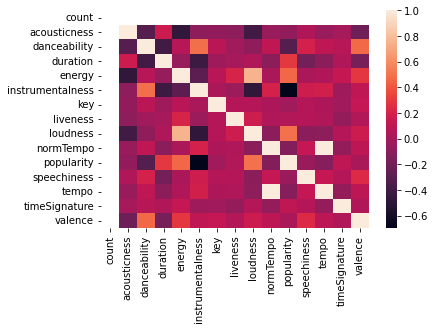

In [26]:
track_Pcount_PD_heatmap=sns.heatmap(track_Pcount_PD.corr())
plt.savefig(r'images/track_Pcount_PD_heatmap.jpg')
print(track_Pcount_PD_heatmap)

In [ ]:
#get the average stats for songs in each country
cypher_country_avgStats='''
MATCH (c:Countries) - [r:COUNTRY_TRACKS] -> (t:Tracks)
RETURN  c.country as countryName, 
count(r) as count, 
avg(t.acousticness) as acousticness,  
avg(t.danceability) as danceability, 
avg(t.duration) as duration, 
avg(t.energy) as energy, 
avg(t.instrumentalness) as instrumentalness, 
avg(t.key) as key, 
avg(t.liveness) as liveness, 
avg(t.loudness) as loudness, 
avg(t.normTempo) as normTempo, 
avg(t.popularity) as popularity, 
avg(t.speechiness) as speechiness, 
avg(t.tempo) as tempo, 
avg(t.timeSignature) as timeSignature, 
avg(t.valence) as valence'''

country_avgStats=spark.read.format("org.neo4j.spark.DataSource")\
    .option("url",bolt_url)\
    .option("query",cypher_country_avgStats)\
    .load()
country_avgStats.toPandas().sort_values(['popularity','energy'],ascending=False)

In [34]:
#now the the differential between a countries song traits averages and the overall collection of songs averages
cypher_countryStats_diff='''
MATCH (s:Tracks)
MATCH (c:Countries) - [r:COUNTRY_TRACKS] -> (t:Tracks)
RETURN  c.country as countryName, count(distinct(r)) as count,
avg(t.acousticness)-avg(s.acousticness) as acousticness,  
avg(t.danceability)-avg(s.danceability) as danceability, 
avg(t.duration)-avg(s.duration) as duration, 
avg(t.energy)-avg(s.energy) as energy, 
avg(t.instrumentalness)-avg(s.instrumentalness) as instrumentalness, 
avg(t.key)-avg(s.key) as key, 
avg(t.liveness)-avg(s.liveness) as liveness, 
avg(t.loudness)-avg(s.loudness) as loudness, 
avg(t.normTempo)-avg(s.normTempo) as normTempo, 
avg(t.popularity)-avg(s.popularity) as popularity, 
avg(t.speechiness)-avg(s.speechiness) as speechiness, 
avg(t.tempo)-avg(s.tempo) as tempo, 
avg(t.timeSignature)-avg(s.timeSignature) as timeSignature, 
avg(t.valence)-avg(s.valence) as valence'''

countryStats_diff=spark.read.format("org.neo4j.spark.DataSource")\
    .option("url",bolt_url)\
    .option("query",cypher_countryStats_diff)\
    .load()
countryStats_diff.toPandas().sort_values(['popularity','energy'],ascending=False)

,countryName,count,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,normTempo,popularity,speechiness,tempo,timeSignature,valence
2,United Kingdom of Great Britain and Northern I...,75,-0.208981,0.007777,4435.474878,0.233940,-0.390600,0.146979,0.010874,3.951399,0.004094,17.555621,0.003222,1.149703,0.081838,0.092096
0,United States of America,100,0.232138,-0.160046,46435.108211,-0.070907,-0.320906,-0.333021,0.001049,-0.147574,-0.100854,3.812287,-0.022295,-10.230474,-0.031496,-0.126466
1,France,166,-0.045423,0.092900,-29976.936367,-0.062981,0.369793,0.134208,-0.005545,-1.696371,0.058906,-10.228315,0.011975,5.643492,-0.018002,0.034575


In [18]:
#show how many playlists each artist shows up on
cypher_artist_PLCount='''
MATCH (a:Artists) - [r:ARTIST_PLAYLISTS] -> ()
RETURN  a.artistName as artistName, count(r) as count
'''
artist_PLCount=spark.read.format("org.neo4j.spark.DataSource")\
    .option("url",bolt_url)\
    .option("query",cypher_artist_PLCount)\
    .load()
artist_PLCount.toPandas().sort_values('count',ascending=False)

,artistName,count
0,Kate Bush,1
1,Lana Del Rey,1
2,Poor Man's Poison,1
3,Rainbow Kitten Surprise,1
4,Phoebe Bridgers,1
...,...,...
250,Cannons,1
251,Zolita,1
252,Markella,1
253,Jake Shears,1


In [37]:
#look at the average song traits for each artist and how many tracks they have across all of the playlists
cypher_artist_avgStats='''
MATCH (a:Artists) - [r:PERFORMS] -> (t:Tracks)
RETURN a.artistName as name,
count(r) as trackCount,
avg(t.acousticness) as acousticness,  
avg(t.danceability) as danceability, 
avg(t.duration) as duration, 
avg(t.energy) as energy, 
avg(t.instrumentalness) as instrumentalness, 
avg(t.key) as key, 
avg(t.liveness) as liveness, 
avg(t.loudness) as loudness, 
avg(t.normTempo) as normTempo, 
avg(t.popularity) as popularity, 
avg(t.speechiness) as speechiness, 
avg(t.tempo) as tempo, 
avg(t.timeSignature) as timeSignature, 
avg(t.valence) as valence'''

artist_avgStats=spark.read.format("org.neo4j.spark.DataSource")\
    .option("url",bolt_url)\
    .option("query",cypher_artist_avgStats)\
    .load()
artist_avgStats.toPandas().sort_values(['popularity','energy'],ascending=False)

,name,trackCount,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,normTempo,popularity,speechiness,tempo,timeSignature,valence
0,Kate Bush,683,0.719000,0.629,298933.0,0.545,0.003080,10.0,0.0604,-13.123,0.081003,87.0,0.0546,108.376,4.0,0.194
198,Purple Disco Machine,683,0.009030,0.690,181478.0,0.890,0.000016,0.0,0.1880,-4.866,0.228643,83.0,0.0507,124.018,4.0,0.713
199,P!nk,683,0.001620,0.636,237200.0,0.888,0.000216,8.0,0.1470,-3.889,0.208968,83.0,0.0945,122.032,4.0,0.250
200,ROSALÍA,683,0.129000,0.555,174045.0,0.634,0.000002,6.0,0.1880,-5.522,0.686444,83.0,0.2730,170.228,4.0,0.555
201,Mareux,683,0.000872,0.485,194423.0,0.890,0.818000,8.0,0.1020,-5.992,0.276821,82.0,0.0911,128.881,4.0,0.258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,Mathis,683,0.085900,0.708,152125.0,0.341,0.734000,2.0,0.2210,-14.203,-0.161414,33.0,0.2340,83.981,4.0,0.448
195,Gold Birds,683,0.009490,0.833,223213.0,0.336,0.851000,10.0,0.1230,-11.566,0.298075,33.0,0.2290,129.997,4.0,0.721
191,Lake Kahn,683,0.357000,0.693,151385.0,0.280,0.768000,9.0,0.3360,-13.001,0.298065,33.0,0.0410,129.996,3.0,0.314
193,Gerythi,683,0.109000,0.710,106808.0,0.275,0.834000,0.0,0.1120,-13.313,-0.250864,33.0,0.1950,75.023,4.0,0.807


In [ ]:
#see how many songs are of each genre type
cypher_genre_songCount='''
MATCH (g:GenreCounts)
RETURN g.genreName as Genre, g.totalSongs as totalSongs
ORDER BY totalSongs DESC
'''

genre_songCount=spark.read.format("org.neo4j.spark.DataSource")\
    .option("url",bolt_url)\
    .option("query",cypher_genre_songCount)\
    .load()
genre_songCount.toPandas().sort_values('totalSongs',ascending=False)

In [8]:
#show genres per country
cypher_country_genreCount='''
MATCH (c) - [r:COUNTRY_GENRE] -> (g)
RETURN c.country as Country,
g.genreName as Genre,
g.totalSongs as TotalSongs
'''

country_genreCount=spark.read.format("org.neo4j.spark.DataSource")\
    .option("url",bolt_url)\
    .option("query",cypher_country_genreCount)\
    .load()
country_genreCount.toPandas().sort_values(['country','totalSongs'],ascending=False)

,c.country,g.genreName,g.totalSongs
0,United States of America,new americana,1368
1,United States of America,folk-pop,2394
2,United States of America,irish singer-songwriter,1368
3,United States of America,pov: indie,2394
4,United States of America,pop,7866
...,...,...,...
207,United Kingdom of Great Britain and Northern I...,pixie,342
208,United Kingdom of Great Britain and Northern I...,pop emo,342
209,United Kingdom of Great Britain and Northern I...,uk dance,342
210,United Kingdom of Great Britain and Northern I...,pop dance,342


### Hive Configuration

In [ ]:
# Set up the Hive Spark connector
spark = SparkSession \
    .builder \
    .master("local") \
    .appName("jupyter-pyspark") \
    .config("hive.metastore.uris", "thrift://hive-metastore:9083") \
    .enableHiveSupport() \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")
print("done")


In [ ]:
# Set up the directories in namenode
# mkdir spotipy
# cd spotipy
# mkdir world_top_playlists
# Use beeline shell commands to make the database and table
# beeline -u jdbc:hive2://hive-server:10000/default
# CREATE DATABASE spotipy;
# USE spotipy;


# read local project data
file = "/home/jovyan/work/IST769_Spotify_Big_Data-main/world_top_playlists.json"
sp_df = spark.read.option("multiline", True).json(file)
sp_df.printSchema()


In [ ]:
# Write to parquet
sp_df.write.parquet("world_top_playlists.parquet", mode="overwrite")
print("done")


In [ ]:
# Write to HDFS
sp_df.write.parquet(
    "webhdfs://namenode:50070/user/spotipy/world_top_playlists/")


In [ ]:
# Read from HDFS
playlists = spark.read.parquet(
    "webhdfs://namenode:50070/user/spotipy/world_top_playlists/", header=True)
playlists.show(2)


In [ ]:
# Make temp view
playlists.createOrReplaceTempView("playlists")
spark.sql("show tables").show()


In [ ]:
# Get the top playlists in the world
query = '''
WITH Source 
AS
(
    SELECT country, top_playlist_name, playlist_id, 
    popularity, norm_tempo, speechiness, energy, danceability, valence
    FROM playlists
)
SELECT top_playlist_name AS topPlaylist, AVG(popularity) AS avgPopularity, 
                            AVG(norm_tempo) AS avgTempo,
                            AVG(speechiness) AS avgSpeech,
                            AVG(energy) AS avgEnergy, 
                            AVG(danceability) AS avgDance,
                            AVG(valence) AS avgValence
FROM Source
GROUP BY top_playlist_name
ORDER BY avgPopularity DESC
'''

top = spark.sql(query)
top.show(2)


In [ ]:
# Set up temp view for top playlists
top.createOrReplaceTempView("top")


In [ ]:
# Put together the list of playlists
playlists = top.toPandas()["topPlaylist"].values

In [ ]:
from IPython.display import display, HTML
from ipywidgets import interact
# Import dependencies
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind
# !pip install seaborn
# !pip install matplotlib
#!pip install scipy

display(HTML("<h2>Compare Top Playlists in the World Today to the Average of All Top Playlists</h2>"))
display(HTML("<h2>Compare Top Playlists in the World Today to the Average of All Top Playlists</h2>"))


@interact(playlist = playlists)
def comboChanged(playlist):
    thePlaylist = top.select('topPlaylist', 'avgPopularity','avgTempo', 'avgSpeech','avgEnergy','avgDance', 'avgValence')\
                        .where(top.topPlaylist == playlist).toPandas().iloc[0]
        
    # Plot all in a radar plot
    feature_list = ['avgTempo', 'avgSpeech','avgEnergy','avgDance', 'avgValence']
    
    sorted_df = top.toPandas()
    
    labels = feature_list
    features = thePlaylist[feature_list].tolist()
    features_all = sorted_df[feature_list].mean().tolist()
    
    # Set up the figure size, grids, and y-axis limits
    num_vars = len(labels)
    angles = np.linspace(0, 2*np.pi, num_vars, endpoint = False)
    fig = plt.figure(figsize = (18,18))
    ax = fig.add_subplot(221, polar = True)

    # Fix axis to go in the right order and start at 12 o'clock
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # Draw axis lines for each angle and label
    ax.set_thetagrids(angles * 180/np.pi, labels, fontsize = 13)

    ax.set_rlabel_position(250)
    plt.yticks([0.1 , 0.2 , 0.3 , 0.4, 0.5,  0.6, 0.7, 0.8, 0.9], ["0.1",'0.2', "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9"], size=12)
    plt.ylim(0,0.9)

    # Plot the top 10 songs from the playlist
    ax.plot(angles, features, 'o-', linewidth = 2, label = f"{thePlaylist['topPlaylist']}", color = 'orange')
    ax.fill(angles, features, alpha = 0.25, facecolor = 'orange')

    # Plot the entire playlist 
    ax.plot(angles, features_all, 'o-', linewidth=2, label = "Average of all top playlists", color= 'blue')
    ax.fill(angles, features_all, alpha = 0.25, facecolor='blue')

    # Go through labels and adjust alignment based on where
    # it is in the circle.
    for label, angle in zip(ax.get_xticklabels(), angles):
        if angle in (0, np.pi):
            label.set_horizontalalignment('center')
        elif 0 < angle < np.pi:
            label.set_horizontalalignment('left')
        else:
            label.set_horizontalalignment('right')

    # Set position of y-labels (0-100) to be in the middle
    # of the first two axes
    ax.set_rlabel_position(180 / num_vars)

    # Add some custom styling.
    # Change the color of the tick labels.
    ax.tick_params(colors='#222222')
    # Make the y-axis (0-100) labels smaller.
    ax.tick_params(axis='y', labelsize=8)
    # Change the color of the circular gridlines.
    ax.grid(color='#AAAAAA')
    # Change the color of the outermost gridline (the spine).
    ax.spines['polar'].set_color('#222222')
    # Change the background color inside the circle itself.
    ax.set_facecolor('#FAFAFA')

    # Annotate the results of the t-test 
    for i, feature in zip(range(0,num_vars), feature_list):

        result = ttest_ind(thePlaylist[feature], sorted_df[feature])
        if result[1] > 0.05:
            result = 'Not significant'
            ax.annotate(result, xy=(angles[i],features[i]), textcoords='data',size=10,ha="center", va="center")
        else:
            result = 'Significant'
            ax.annotate(result, xy=(angles[i],features[i]), textcoords='data',size=10,ha="center", va="center")

    # Add the title and legend
    display(HTML(f"<h3>{thePlaylist['topPlaylist']}</h3>"))
    ax.grid(True)
    plt.legend(loc='lower right', bbox_to_anchor=(0.1, 0.1))
        